<a href="https://colab.research.google.com/github/joshuabare/MachineLearning/blob/main/Bare_Embeddings_CNNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size= 160000
#Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []



In [ ]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        # YOUR CODE HERE
        if row[0] == '0':
            list_item.append(row[5])
            list_item.append(0)
        else:
            list_item.append(row[5])
            list_item.append(1)

        num_sentences = num_sentences + 1
        corpus.append(list_item)

--2025-10-24 18:15:45--  https://storage.googleapis.com/learning-datasets/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  23.5MB/s    in 11s     

2025-10-24 18:15:57 (20.2 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [ ]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [ ]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])  # the text (string)
    labels.append(corpus[x][1])     # the label (0 or 1)

print(sentences[:2])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences) # gives each work an index

word_index = tokenizer.word_index # created from fits on texts and is the dictionary conatining the words with an id
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences) # you tokenize the sentences
padded = pad_sequences(sequences=sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:]
test_labels = labels[0:split]
training_labels = labels[split:]

['ooh bought some new shoes today! 6 quid what a frigin bargain!!  pic of my legs and my feet lol! http://twitpic.com/7h2rv', '@rach210 Ooooh Too close for comfort totally one of the most amazing songs! Did i send you the acoustic version? -love it so much- ']


In [ ]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138125
1


In [ ]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2025-10-24 18:16:26--  https://storage.googleapis.com/learning-datasets/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 74.125.24.207, 172.217.70.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-10-24 18:16:27 ERROR 404: Not Found.



In [ ]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138126


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=-1)),
])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

num_epochs = 50
training_sequences = np.asarray(training_sequences, dtype=np.int32)
test_sequences      = np.asarray(test_sequences, dtype=np.int32)

training_labels = np.asarray(training_labels, dtype=np.float32)
test_labels      = np.asarray(test_labels, dtype=np.float32)
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    13,812,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,812,600 (52.69 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,812,600 (52.69 MB)

Epoch 1/50
4500/4500 - 15s - 3ms/step - accuracy: 0.5031 - loss: 0.6932 - val_accuracy: 0.5100 - val_loss: 0.6931
Epoch 2/50
4500/4500 - 14s - 3ms/step - accuracy: 0.4962 - loss: 0.6932 - val_accuracy: 0.5100 - val_loss: 0.6931
Epoch 3/50
4500/4500 - 12s - 3ms/step - accuracy: 0.5093 - loss: 0.6932 - val_accuracy: 0.5100 - val_loss: 0.6932
Epoch 4/50
4500/4500 - 11s - 3ms/step - accuracy: 0.5140 - loss: 0.6932 - val_accuracy: 0.5100 - val_loss: 0.6932
Epoch 5/50
4500/4500 - 12s - 3ms/step - accuracy: 0.4896 - loss: 0.6932 - val_accuracy: 0.5100 - val_loss: 0.6932
Epoch 6/50
4500/4500 - 12s - 3ms/step - accuracy: 0.4944 - loss: 0.6932 - val_accuracy: 0.5100 - val_loss: 0.6931
Epoch 7/50
4500/4500 - 12s - 3ms/step - accuracy: 0.4953 - loss: 0.6932 - val_accuracy: 0.5100 - val_loss: 0.6931
Epoch 8/50
4500/4500 - 12s - 3ms/step - accuracy: 0.5098 - loss: 0.6932 - val_accuracy: 0.5100 - val_loss: 0.6931
Epoch 9/50
4500/4500 - 12s - 3ms/step - accuracy: 0.5036 - loss: 0.6932 - val_accuracy: 

<Figure size 640x480 with 0 Axes>

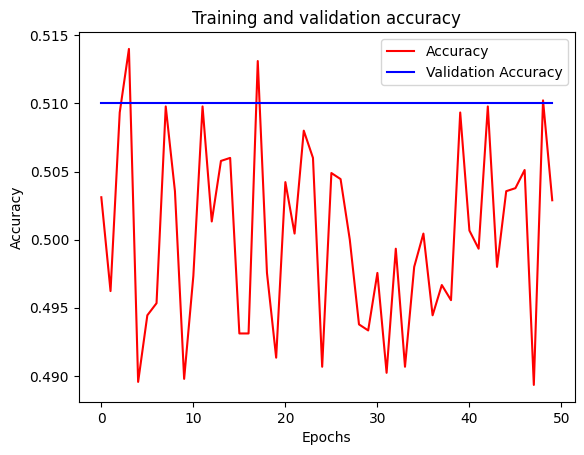

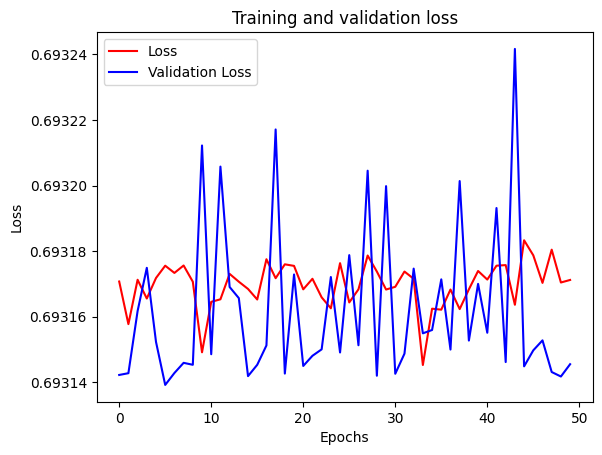

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!